In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
url = "https://www.melon.com/chart/index.htm"

In [5]:
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
}

In [6]:
res = requests.get(url, headers=headers)
res

<Response [200]>

In [12]:
html = res.text
print(repr(html[:100]))
soup = BeautifulSoup(html, "html.parser")

'<!DOCTYPE html>\r\n<html lang="ko">\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n<head>\r\n\t\t\r\n\t\r\n\t\r\n\t\r\n\t\r\n\t\r\n\t\r\n\t\r\n\t\r\n\r\n\t'


In [19]:
# wrap_tag_list = soup.select(".service_list_song tbody tr")
# wrap_tag_list = soup.select(".lst50, .lst100")

wrap_tag_list = soup.select("tr[data-song-no]")
len(wrap_tag_list)

100

In [37]:
song_list = []

for wrap_tag in wrap_tag_list:
    song_no = wrap_tag["data-song-no"]

    # wrap_tag.select_one("[href^=playSong]")  # href.startswith("playSong")의 의미
    # wrap_tag.select_one("[href$=playSong]")  # href.endswith("playSong")의 의미
    song_title = wrap_tag.select_one("[href*=playSong]").text  # "playSong" in href 의 의미
    artist_name = wrap_tag.select_one("[href*=goArtistDetail]").text
    album_name = wrap_tag.select_one("[href*=goAlbumDetail]")["title"]
    
    cover_image_url = wrap_tag.select_one("[onerror*=defaultAlbumImg]")["src"]

    song_list.append({
        "곡일련번호": song_no,
        "앨범명": album_name,
        "곡명": song_title,
        "가수명": artist_name,
        "커버이미지_주소": cover_image_url,
    })
    
    # print(song_no, album_name, song_title, artist_name, cover_image_url)

len(song_list)

100

In [47]:
import pandas as pd

df = pd.DataFrame(song_list).set_index("곡일련번호")
df["순위"] = range(1, df.shape[0] + 1)
print(df.shape)
df.head()

(100, 5)


,앨범명,곡명,가수명,커버이미지_주소,순위
곡일련번호,,,,,
36599950,NewJeans 2nd EP 'Get Up',Super Shy,NewJeans,https://cdnimg.melon.co.kr/cm2/album/images/11...,1
36617841,Seven (feat. Latto) - Clean Ver.,Seven (feat. Latto) - Clean Ver.,정국,https://cdnimg.melon.co.kr/cm2/album/images/11...,2
36635522,NewJeans 2nd EP 'Get Up',ETA,NewJeans,https://cdnimg.melon.co.kr/cm2/album/images/11...,3
36430773,I feel,퀸카 (Queencard),(여자)아이들,https://cdnimg.melon.co.kr/cm2/album/images/11...,4
36382580,1집 Alone,헤어지자 말해요,박재정,https://cdnimg.melon.co.kr/cm2/album/images/11...,5


In [58]:
url = "https://www.melon.com/commonlike/getSongLike.json"
params = {
    "contsIds": "36599950,36617841",
}

res = requests.get(url, params=params, headers=headers)
res

<Response [200]>

In [65]:
likes_dict = {}

for song in res.json()['contsLike']:
    print(song["CONTSID"], song["SUMMCNT"])
    likes_dict[song["CONTSID"]] = song["SUMMCNT"]

likes_dict

36599950 102866
36617841 107070


{36599950: 102866, 36617841: 107070}

In [67]:
# dict comprehension
{
    song["CONTSID"]: song["SUMMCNT"]
    for song in res.json()['contsLike']
}

{36599950: 102866, 36617841: 107070}

In [70]:
numbers = [1, 2, 3, 4, 5]

[number ** 2 for number in numbers]  # list comprehension
[number ** 2
 for number in numbers
 if number % 2 == 0]  # list comprehension

[4, 16]

In [73]:
{ number % 3 for number in numbers }  # set comprehension

{0, 1, 2}

In [74]:
{ number: number % 3 for number in numbers }  # dict comprehension

{1: 1, 2: 2, 3: 0, 4: 1, 5: 2}

In [75]:
(number ** 2 for number in numbers)  # tule comprehension은 없다 !!!

<generator object <genexpr> at 0x177f7dcb0>

# 좋아요 요청

In [79]:
conts_ids = ",".join(df.index)

In [80]:
url = "https://www.melon.com/commonlike/getSongLike.json"
params = {
    "contsIds": conts_ids,
}

res = requests.get(url, params=params, headers=headers)
res

<Response [200]>

In [90]:
# dict comprehension
likes_dict = {
    str(song["CONTSID"]): int(song["SUMMCNT"])
    for song in res.json()['contsLike']
}
len(likes_dict)

100

In [91]:
type(list(likes_dict.keys())[0])

str

In [92]:
df["좋아요수"] = likes_dict
print(df.shape)
df.head()

(100, 6)


,앨범명,곡명,가수명,커버이미지_주소,순위,좋아요수
곡일련번호,,,,,,
36599950,NewJeans 2nd EP 'Get Up',Super Shy,NewJeans,https://cdnimg.melon.co.kr/cm2/album/images/11...,1,102894
36617841,Seven (feat. Latto) - Clean Ver.,Seven (feat. Latto) - Clean Ver.,정국,https://cdnimg.melon.co.kr/cm2/album/images/11...,2,107102
36635522,NewJeans 2nd EP 'Get Up',ETA,NewJeans,https://cdnimg.melon.co.kr/cm2/album/images/11...,3,43351
36430773,I feel,퀸카 (Queencard),(여자)아이들,https://cdnimg.melon.co.kr/cm2/album/images/11...,4,122594
36382580,1집 Alone,헤어지자 말해요,박재정,https://cdnimg.melon.co.kr/cm2/album/images/11...,5,88980


In [97]:
song_count_series = df.groupby("가수명").size().sort_values(ascending=False)
song_count_series

가수명
임영웅                     15
NCT DREAM               11
NewJeans                10
방탄소년단                    6
IVE (아이브)                4
Charlie Puth             4
(여자)아이들                  4
정국                       3
LE SSERAFIM (르세라핌)       3
이무진                      1
#안녕                      1
윤하 (YOUNHA)              1
우디 (Woody)               1
오마이걸 (OH MY GIRL)        1
세븐틴 (SEVENTEEN)          1
성시경                      1
이채연                      1
제이세라                     1
임재현                      1
임한별                      1
지민                       1
지수 (JISOO)               1
지아                       1
케이시 (Kassy)              1
탑현                       1
테이                       1
부석순 (SEVENTEEN)          1
던 (DAWN)                 1
박재정                      1
The Kid LAROI            1
Agust D                  1
DK(디셈버)                  1
EXO                      1
FIFTY FIFTY              1
H1-KEY (하이키)             1
Lauv                     1
Paul Blanco             

In [100]:
import matplotlib.pyplot as plt
import platform

if platform.system() == "Darwin":
    plt.rc("font", family="AppleGothic")  # macOS 시스템 기본 폰트

elif platform.system() == "Windows":
    plt.rc("font", family="Malgun Gothic")  # Windows 시스템 기본 폰트

<Axes: xlabel='가수명'>

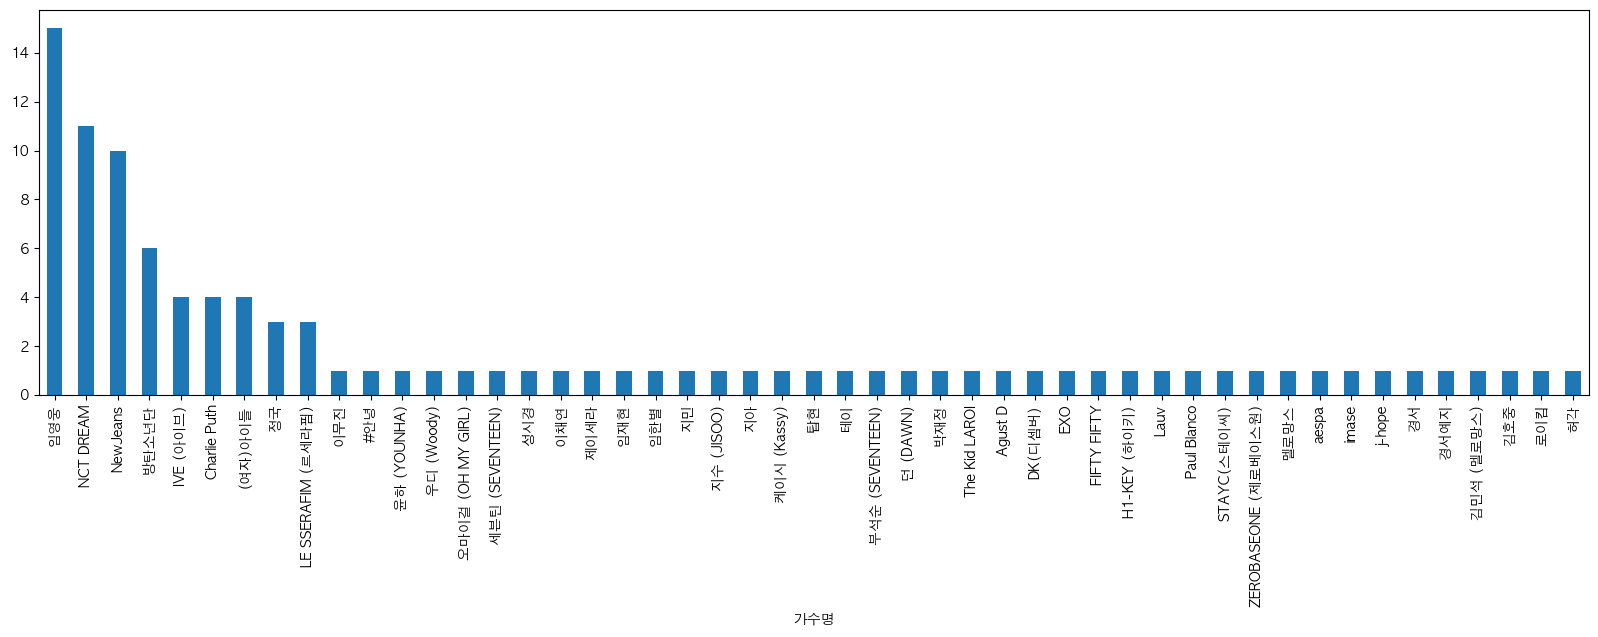

In [103]:
song_count_series.plot(kind="bar", figsize=(20, 5)) 

In [109]:
mask = song_count_series > 1  # boolean mask
chart_series = song_count_series[mask]
chart_series

가수명
임영웅                   15
NCT DREAM             11
NewJeans              10
방탄소년단                  6
IVE (아이브)              4
Charlie Puth           4
(여자)아이들                4
정국                     3
LE SSERAFIM (르세라핌)     3
dtype: int64

In [114]:
mask = song_count_series == 1
chart_series["Others"] = song_count_series[mask].sum()
chart_series

가수명
임영웅                   15
NCT DREAM             11
NewJeans              10
방탄소년단                  6
IVE (아이브)              4
Charlie Puth           4
(여자)아이들                4
정국                     3
LE SSERAFIM (르세라핌)     3
Others                40
dtype: int64

<Axes: >

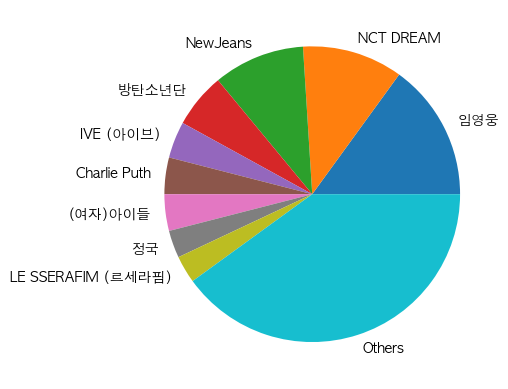

In [117]:
chart_series.plot(kind="pie")